# Assignment 4

Your task is to write code for learning the parameters of an aircraft encounter model from data.
Using the provided airplane trajectories you will:

1.  Learn an initial scene model
2.  Learn a dynamics model

The file flights.csv (inside 'data' directory) is formatted identically to the previous assignment.
Use the provided data to learn your models.

### **What is Turned In:**
Edit the contents of this notebook and turn in our final Julia notebook file (.ipynb), and any associated code files you wrote to Coursework. Do not use any external code or Julia packages other than those used in the class materials.

### Set Up

In [17]:
using CSV, DataFrames

### Load the Dataset

In [18]:
flights = CSV.read(joinpath(@__DIR__, "..", "data", "flights.csv"))
flights[1:3,:] # first three rows

,id,x1,y1,u1,v1,x2,y2,u2,v2,t
,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,1,0.0,10313.0,224.604,0.0213703,-897.73,10112.0,243.037,0.480057,0
2,1,224.638,10313.0,224.673,-0.0922206,-654.645,10112.5,243.131,0.458075,1
3,1,449.327,10312.9,224.705,-0.185167,-411.497,10113.0,243.165,0.448498,2


## Milestone One: Initial Conditions Model

First, we implement a simple initial conditions model. From the figure below, we see that aircraft 1 is always considered to be at x=0.0 and and moves with horizontal speed $u_1$ which affects how close aircraft 2, or $\Delta x$ and vertical speed $v_1$, which affects $y_1$ and $\Delta y$. In general, we see that the initial conditions can be defined by $y_1$, $u_1$, $v_1$, $\Delta x$, and $\Delta y$.

You need to develop your own initial conditions model, then write your code here to implement the data structure for the probabilty distribution. We have provided the following starter code and would like you to use the speeds and positions of the aircraft at t=40s and go back linearly to determine intial positions at t=0s, using the given speeds for both aircraft at 40s. 

![Encounter](figures/encounter_def.png)

Again, this simple model thus defines a probability distribution as follows:

$$P(y_1, u_1, v_1, \Delta x, \Delta y, \Delta u, \Delta v)$$

We have learned the probability distribution over the initial conditions model for you already. First, in **Pull Raw Data**, we create a categorical distrubution and then with **Discretize Dataset**, as the name states, we discretize the continuous variables into bins that we have defined for you below. Finally, we train a discrete Bayesian network over the discrete dataset in **Fit Distributions**.

We have done this for the initial conditions model for you already. Please take the time to read through each step because you will be asked to go through this process for the Dynamics Model.

### Pulling the Raw Data

In [19]:
trajectories = pull_trajectories(flights, 100)

#extract flights, length of array 
N = length(trajectories)

#Initializes a data frame to store the inital conditions
data_initial = DataFrame(
    y1 = Float64[],
    u1 = Float64[],
    v1 = Float64[],
    Δx = Float64[],
    Δy = Float64[],
    Δu = Float64[],
    Δv = Float64[],
)

for traj in trajectories
    P1 = traj[41].plane1
    P2 = traj[41].plane2
    
    y1, u1, v1 = P1.y, P1.u, P1.v
    Δx = P2.x - P1.x
    Δy = P2.y - P1.y
    Δu = P2.u - P1.u
    Δv = P2.v - P1.v
    if Δx < 0
        Δx *= -1
        Δu *= -1
    end
    
    push!(data_initial, [y1,u1,v1,Δx,Δy,Δu,Δv])
end

data_initial[1:3,:] # first three rows

,y1,u1,v1,Δx,Δy,Δu,Δv
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10178.9,225.032,-5.69799,139.028,23.12,-19.0499,10.4739
2,11657.3,226.895,-4.47351,6.23307,-24.7549,3.82431,13.7632
3,10362.9,221.108,13.8988,92.8155,3.3539,7.47468,-14.5272


### Discretize Dataset

In [20]:
using Discretizers

D = Dict{Symbol,LinearDiscretizer}(
    sym=>LinearDiscretizer(binedges(DiscretizeUniformWidth(6), data_initial[sym]))
    for sym in names(data_initial)
)

for (sym, disc) in D
    data_initial[sym] = encode(disc, data_initial[sym]) 
end

ncategories = [nlabels(D[:y1]), nlabels(D[:u1]), nlabels(D[:v1]),
               nlabels(D[:Δx]), nlabels(D[:Δy]), nlabels(D[:Δu]), nlabels(D[:Δv])]

data_initial[1:3,:]

,y1,u1,v1,Δx,Δy,Δu,Δv
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,4,4,3,6,6,1,4
2,6,4,3,1,1,3,4
3,4,3,4,4,4,3,2


###  Fit Distributions

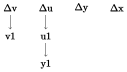

In [21]:
using Random, BayesNets

Random.seed!(0)
params = GreedyHillClimbing(ScoreComponentCache(data_initial), max_n_parents=3, 
prior=UniformPrior())
bn_initial = fit(DiscreteBayesNet, data_initial, params, ncategories=ncategories)

### Sampling

#### Sample from Initial to get Initial Scene

We now have to implement `Base.rand(model)` which should generate random Encounters from our given initial conditions model.


In [22]:
struct DiscretizedBayesNet
    dbn::DiscreteBayesNet
    discs::Dict{Symbol, LinearDiscretizer}
end

In [23]:
function Base.rand(bn::DiscretizedBayesNet)
    sample = rand(model.dbn) # pull from discrete Bayes net
    
    # convert discrete samples to continuous samples
    for (sym, disc) in bn.discs
        sample[sym] = decode(disc, sample[sym]) 
    end

    return sample
end

## Milestone Two: Dynamics Model

Now that you are familiar with the implementation of the Initial Conditions Model, we would like you to train and learn over the probability distribution of a Dynamics Model. We can define the dynamics model by the horizontal and vertical accelerations given the change in distance and change in velocities. A simple uncorrelated dynamics model represents:

$$P(\Delta u_t, \Delta v_t \mid \Delta x_{t-1}, \Delta y_{t-1}, \Delta u_{t-1}, \Delta v_{t-1})$$

We will train:

$$P(\Delta u_t, \Delta v_t, \Delta x_{t-1}, \Delta y_{t-1}, \Delta u_{t-1}, \Delta v_{t-1})$$

Again, we would like to improve the model like how we did with the intial conditions model. Here are a few ways of improving the given model:

1. Add additional three conditional variables: acceleration, climbrate, and turnrate
             
2. Include other variables (current altitude, aircraft type, etc.)

Develop your own dynamics model of probability dsitribution using a Discrete Bayesian.

Use the following code as a starting point. You have until week 5 to work on it.

### Pull Raw Data

We would now like you to pull the data from the flights dataset in order to fill the data_transition data array. You can use the code from the initial model as a reference. We want to load the both the horizontal and vertical acceleration for both aircraft. Think in terms of how we could do that given u1, v1, and u2, v2. (Remember that acceleration is $\frac{\Delta velocity}{\Delta time}$. 

We have provided the size of the array below and the DataFrame, now you just need to load the data in below. (**Hint:** you will find the findnext() function useful in a for loop while loading data from flights into data_transition)

In [24]:
#Define N : N = 
M = 2*51*N # 2 aircraft per run, 51 frame-deltas per run

data_transition = DataFrame(
    du2=Array{Float64}(undef, M), # current change in horizontal accel  [m/s2]
    dv2=Array{Float64}(undef, M), # currenct change in vertical accel   [m/s2]
    dx1=Array{Float64}(undef, M), # previous change in x                [m]
    dy1=Array{Float64}(undef, M), # previous change in y                [m]
    du1=Array{Float64}(undef, M), # previous change in hoizontal speed  [m/s2]
    dv1=Array{Float64}(undef, M), # previous change in vertical speed   [m/s2]
)

j = 1
i = 0
flightids = flights[:id]

# Use a for loop to fill the DataFrame above with the data from loaded flights.csv file

# STUDENT CODE START
# STUDENT CODE END

data_transition[1:3,:] # first three rows

,du2,dv2,dx1,dy1,du1,dv1
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0316606,-0.0929461,224.638,-0.0439552,0.0692497,-0.113591
2,0.033982,-0.00957674,243.084,0.45891,0.0935041,-0.021982
3,-0.098043,-0.0528164,224.689,-0.133604,0.0316606,-0.0929461


### Discretize Data

Think about how you might want to tune the discretization of the data

In [25]:
using Discretizers

D_trans = Dict{Symbol,LinearDiscretizer}()
D_trans[:du2] = LinearDiscretizer(Float64[0,30,60,90,120,150,180]) # [m/s2]
D_trans[:dv2] = LinearDiscretizer(Float64[150,365,915,1520,3800])  # [m/s2]
D_trans[:dx1] = LinearDiscretizer(Float64[0,30,60,90,120,150,180])   # [m]
D_trans[:dy1] = LinearDiscretizer(Float64[150,365,915,1520,3800])   # [m]
D_trans[:du1] = LinearDiscretizer(Float64[0,30,60,90,120,150,180]) # [m/s2]
D_trans[:dv1] = LinearDiscretizer(Float64[150,365,915,1520,3800])  # [m/s2]

for (sym, disc) in D_trans
    data_transition[sym] = encode(disc, data_transition[sym]) 
end

n_trans_categories = [nlabels(D_trans[:du2]), nlabels(D_trans[:dv2]),
                      nlabels(D_trans[:dx1]), nlabels(D_trans[:dy1]),
                      nlabels(D_trans[:du1]), nlabels(D_trans[:dv1])]

data_transition[1:3,:]

,du2,dv2,dx1,dy1,du1,dv1
,Int64,Int64,Int64,Int64,Int64,Int64
1,1,1,6,1,1,1
2,1,1,6,1,1,1
3,1,1,6,1,1,1


### Fit Distributions

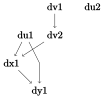

In [26]:
params = GreedyHillClimbing(ScoreComponentCache(data_transition), max_n_parents=3, 
prior=UniformPrior())
bn_transition = fit(DiscreteBayesNet, data_transition, params, ncategories=n_trans_categories)

###  Sampling

Finally, we would like to sample the data given. We have already implemented the discretize assignment and would like you to convert the discrete samples to continuous samples. Use the method in the initial model as a reference. 

In [27]:
function Base.rand(bn::DiscretizedBayesNet, evidence::Assignment)
    
    # discretize the assignment
    for (sym, disc) in bn.discs
        evidence[sym] = encode(disc, evidence[sym]) 
    end
    
    sample = rand(model.dbn, evidence) # pull from discrete Bayes net
    
    # convert discrete samples to continuous samples
    
    # STUDENT CODE START
    # STUDENT CODE END
    
    return sample
end

### Saving

In [28]:
using BSON
using BSON: @save
bson("myencountermodel.bson", Dict(:initial => bn_initial, :initdisc => D, :transition => bn_transition, :transdisc => D_trans))